# Virtual screening 

We have successfully trained several models. The next step is to use these models to predict binding affinity with an unknown screening dataset to discover novel potential EGFR inhibitors.

An example of a large screening dataset is MolPort, which contains over 7 million compounds. 

For demonstration purposes, we will perform virtual screening on a smaller library of 20,000 compounds specifically designed for discovering novel kinase ATP pocket binders.

In [62]:
import pickle
import numpy as np
import datamol as dm 

In [2]:
# load commercial screening library
lib_path = "data/Enamine_Hinge_Binders_Library_plated_24000cmds_20210316.sdf"
lib_df = dm.read_sdf(lib_path, as_df=True, mol_column="mol")

#### Check the library statistics

In [3]:
lib_df.describe()

,MW (desalted),CLogP,HBD,TPSA,RotBonds
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,348.377242,2.339357,1.406417,75.599830,4.600583
std,53.655375,1.339740,0.738477,19.544894,1.584347
min,177.226000,-2.841000,0.000000,19.370000,0.000000
25%,312.409000,1.418000,1.000000,61.880000,3.000000
50%,341.336000,2.370000,1.000000,74.610000,5.000000
75%,382.502250,3.250000,2.000000,87.910000,6.000000
max,544.355000,8.833000,5.000000,167.930000,15.000000


In [4]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x174c3bdf0>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x174cefdf0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x174d442e0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x174d44820>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x174d44a50>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


In [5]:
#### Load the pre-trained model and transformer

In [6]:
# load the fingerprint transformer and random forest model
with open("model/rf_regressor.pkl", "rb") as f:
    fp_transformer, rf_model = pickle.load(f)

In [7]:
# load the transformer and selected model
with open("model/gnn_classifer.pkl", "rb") as f:
    pyg_transformer, gnn_model = pickle.load(f)

### Scoring the compounds in the library with the predictive models

Let's begin by defining a scoring function that converts the molecular SMILES to feature inputs for the predictive models and predicts their binding affinity to EGFR.

In [8]:
import torch 
from gnn import GCNModel
def score(mol, transformer, model, is_reg = True):
    try:
        # compute the molecular features
        feat = transformer(mol)
        if isinstance(model, GCNModel): # if 
            feat = transformer.get_collate_fn()(transformer(mol))[0]
        # score the molecule
        if is_reg:
            score = model.predict(feat)
        else:
            score = model.predict_proba(feat)[:, 1]
        if torch.is_tensor(score):
            score = score.flatten().numpy()
    except Exception as e:
        score = None
    return score

In [9]:
# Parallelize the scoring with 
lib_df["rf_preds_pIC50"] = dm.utils.parallelized_with_batches(fn=lambda mol: score(mol, fp_transformer, rf_model), inputs_list=lib_df.smiles.values, batch_size=1000, progress=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [10]:
# Parallelize the scoring
lib_df["gnn_preds_pIC50"] = dm.utils.parallelized_with_batches(fn=lambda mol: score(mol, pyg_transformer, gnn_model), inputs_list=lib_df.smiles.values, batch_size=1000, progress=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [11]:
print("Number of compounds having predicted pIC50 greater than 6: ", lib_df["rf_preds_pIC50"].gt(6).sum())
print("Number of compounds having predicted pIC50 greater than 7: ", lib_df["rf_preds_pIC50"].gt(7).sum())

Number of compounds having predicted pIC50 greater than 6:  1347
Number of compounds having predicted pIC50 greater than 7:  108


## Compound prioritization

To define an active compound, an activity cut-off ranging from an pIC50 value of 5 to 7 in drug discovery programs. 

In this tutorial, we use pIC50 of 6 is a common cut-off value to define an active compound. 



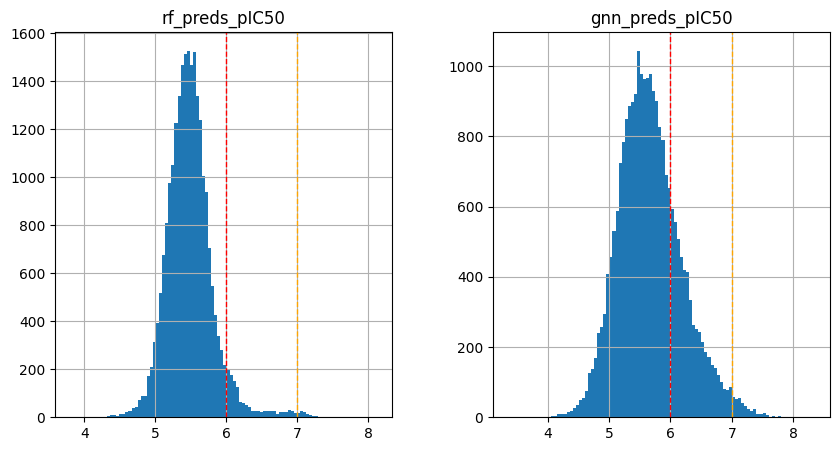

In [12]:
from matplotlib import pyplot as plt
fig = lib_df[["rf_preds_pIC50", "gnn_preds_pIC50"]].hist(bins=100, figsize=(10, 5))

for ax in fig[0]:
    ax.axvline(6, color='red', linestyle='dashed', linewidth=1,)
    ax.axvline(7, color='orange', linestyle='dashed', linewidth=1)

We have to make sure that non of the prioritiezed compounds are already in the training set. Therefore, we compare the `unique_id` of molecules, and exlude the repeated molecules from the prioritized set.

In [13]:
import pandas as pd

# Compute the unique id
data_train = pd.read_csv("data/egfr_pIC50.csv")
data_train["uid"] = data_train["MOL_smiles"].apply(lambda smi: dm.unique_id(dm.to_mol(smi)))

lib_df_gt_6 = lib_df.query("rf_preds_pIC50 > 6")
lib_df_gt_6["uid"] = lib_df_gt_6["mol"].apply(dm.unique_id).values

/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/ipykernel_61978/1542837347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lib_df_gt_6["uid"] = lib_df_gt_6["mol"].apply(dm.unique_id).values


In [14]:
# Exclude the molecules in training set from the prioritized set
lib_df_gt_6 = lib_df_gt_6.query("uid not in @data_train.uid")
print("Number of compounds having predicted pIC50 greater than 6: ", lib_df_gt_6["rf_preds_pIC50"].gt(6).sum())
print("Number of compounds having predicted pIC50 greater than 7: ", lib_df_gt_6["rf_preds_pIC50"].gt(7).sum())

Number of compounds having predicted pIC50 greater than 6:  1346
Number of compounds having predicted pIC50 greater than 7:  107


### Distribution in chemical space
Now let's check the distribution of training set and screening set in chemical space.

In [19]:
train_feat = fp_transformer(data_train["MOL_smiles"])
lib_feat = fp_transformer(lib_df_gt_6["mol"])

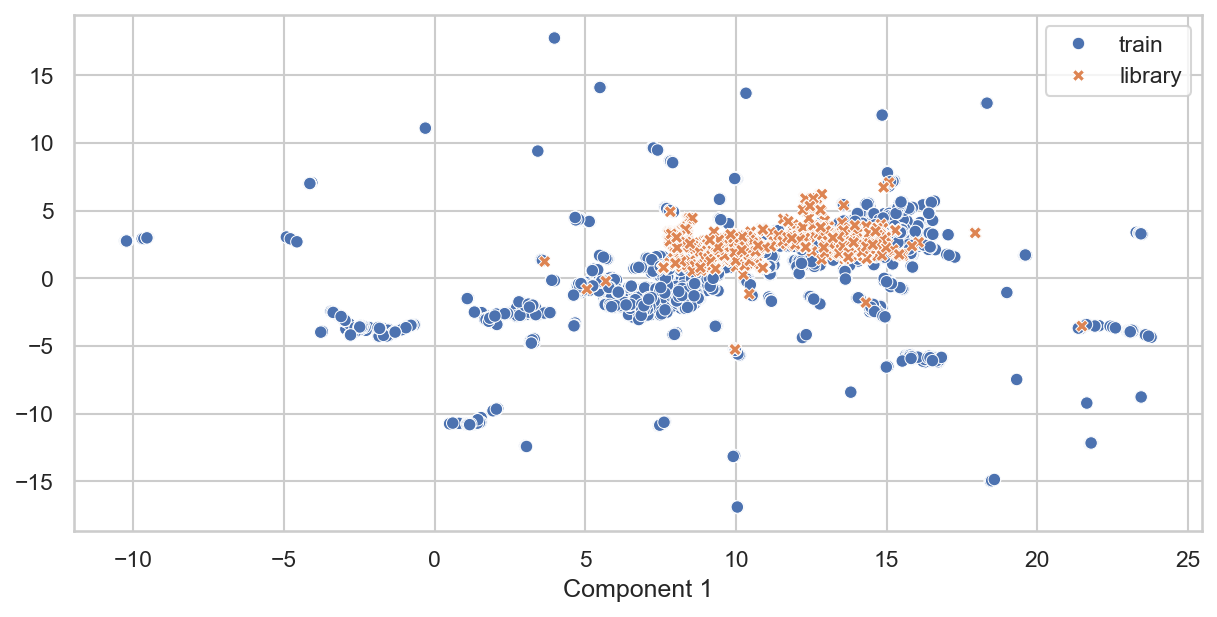

In [21]:
from auroris.visualization import visualize_chemspace
fig = visualize_chemspace(X=np.concatenate([train_feat, lib_feat]), 
                          y=np.array(["train"] * len(train_feat) +["library"] * len(lib_feat)))

The prioritized molecules (highlighted in orange) are mainly distributed in one cluster in the middle. Now we can use the predicted `pIC50` value to rank order the screened compounds and select a diverse set of these molecules for furture steps. 

#### Diverse pick of selected molecules
In drug discovery and development, selecting a diverse set of molecules is a critical step to ensure a comprehensive exploration of chemical space. This diversity maximizes the chances of identifying promising lead compounds with varying structural and functional characteristics. 

In [32]:
# Rank the molecules by pIC50
lib_df_gt_6_ranked = lib_df_gt_6.sort_values(by="rf_preds_pIC50", ascending=False).reset_index(drop=True)

In [55]:
# Select 100 most diverse molecules from the set
picked_index, _ = dm.pick_diverse(mols=lib_df_gt_6_ranked.mol.values, npick= 100, initial_picks=range(10) )
lib_df_picked = lib_df_gt_6_ranked.iloc[picked_index]

Now we visualize the picked molecules.

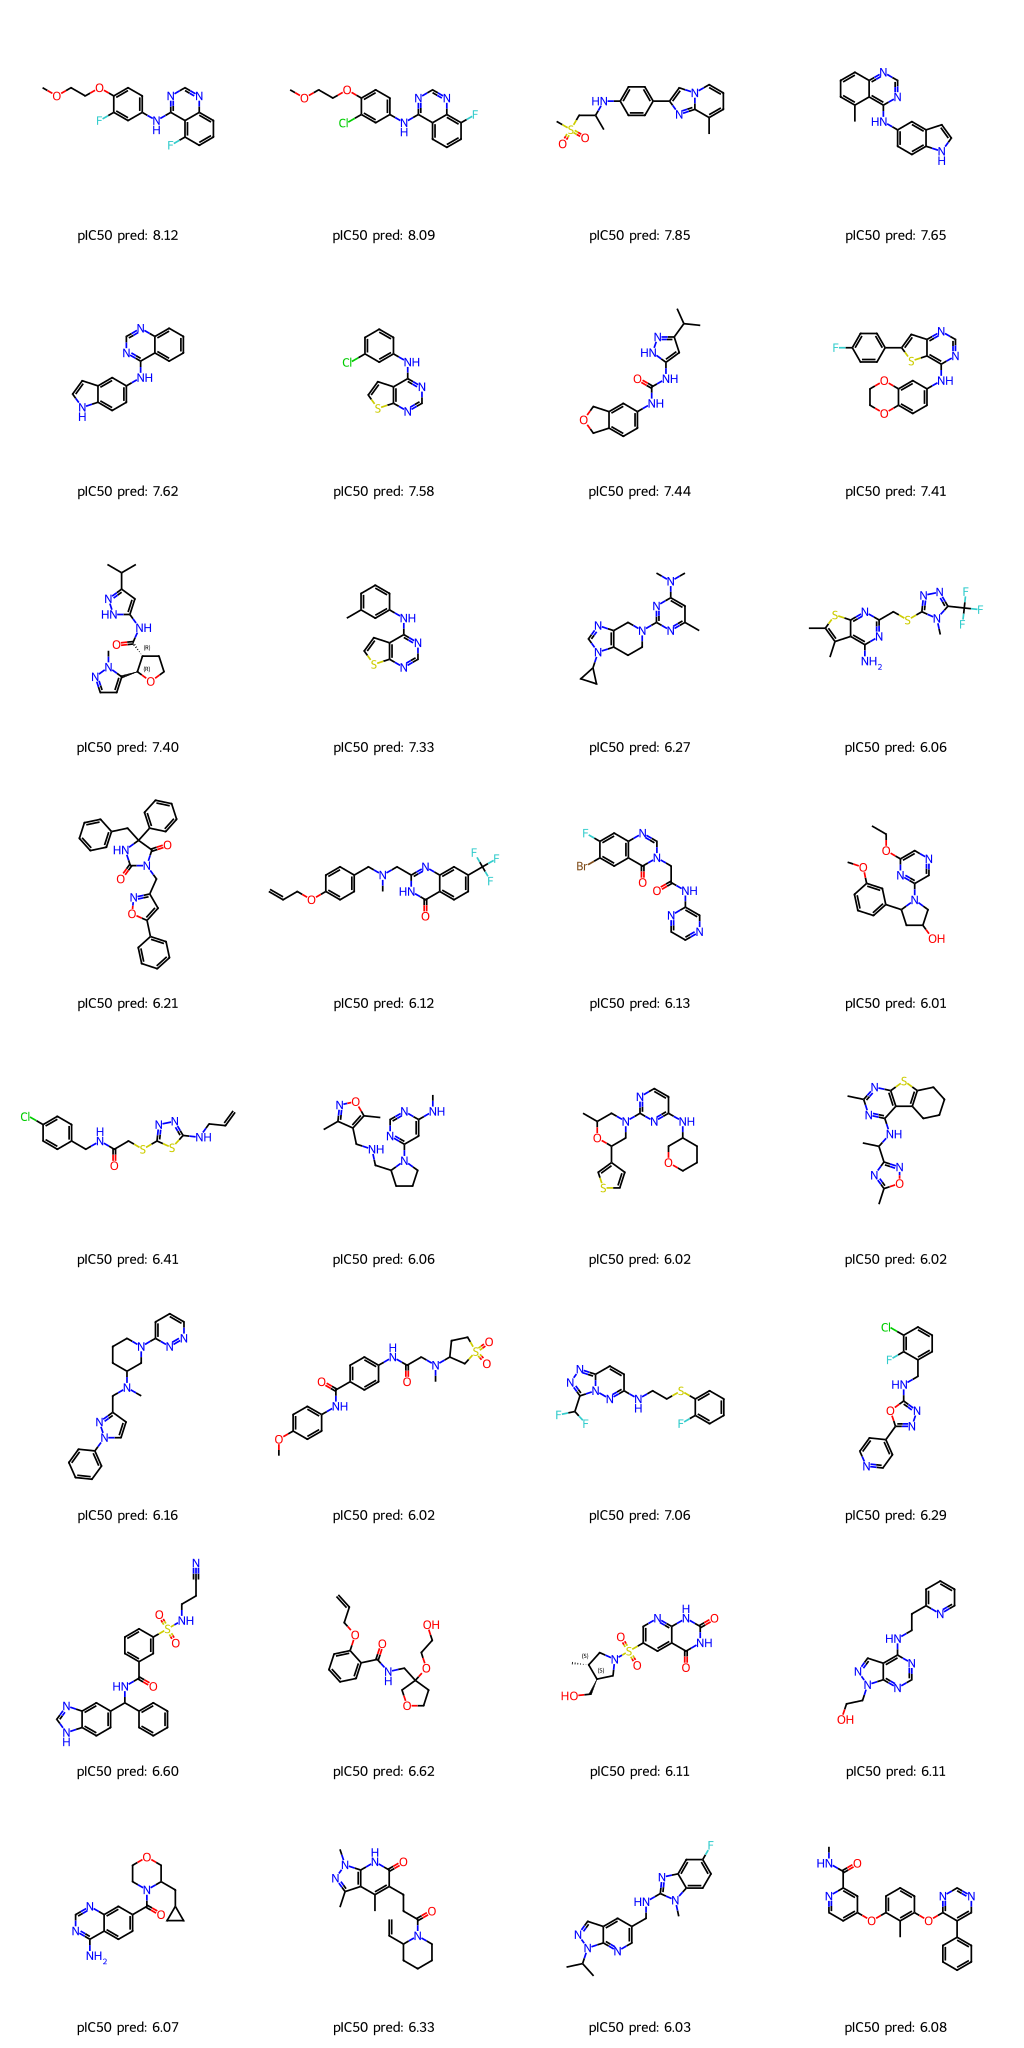

In [57]:
legends = lib_df_picked["rf_preds_pIC50"].apply(lambda x: 'pIC50 pred: {:,.2f}'.format(x)).tolist()
dm.to_image(lib_df_picked.mol.tolist(), legends=legends)


Our models could be used to rank the compounds and then further study those with the highest predicted binding affinity.


In [61]:
# Export the selected molecules
lib_df_picked.drop(columns="mol").to_csv("output/picked100mols.csv", index=False)

## Discussion

- Is the current screening library a good choice for our dataset?
- What other factors to be considered to propose the final 100 candidates?